# 1 - Imports e Setup
$\alpha := 5 \%$ !!!

## 1.1 - Bibliotecas necessárias

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from numpy import random as rd
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 8]
plt.rcParams['figure.dpi'] = 100 # 200 e.g. is really fine, but slower
sns.set_theme(context="notebook")
from tqdm import tqdm

# scipy.fft é melhor !
# https://stackoverflow.com/questions/6363154/what-is-the-difference-between-numpy-fft-and-scipy-fftpack
from scipy.fft import fft
from scipy.fftpack.helper import fftfreq

from scipy.stats import f as FDIST
from scipy.stats.distributions import chi2

In [2]:
# Calcula valor crítico em ORD qualquer, calculando quantil 95%
def vc_pratico(ORD, alpha = 0.05):
    return np.quantile(a= ORD, q = 1-alpha)

## 1.2 - Geração de sinais senoidais:

In [181]:
# Construção de senóide aleatória com e sem ruído:
# Senoide normal:   sin(2 * np.pi * t + th0 )
# Senoide discreta: sin(2 * np.pi * n * ts + th0);
# => ts = 1/fs; t = n/fs

# Frequência do Sinal: [Hz]
f0 = 100

# Frequeência de Amostragem: [Hz]
fs = 1000

# Frequência da senoide discreta: [rad/s]
fl = 2*np.pi*f0/fs

# Duração da amostragem: (tempo de experimento) [s]
tj = fs # Tempo por janela = fs => 1s / janela! (facilita contas) 
M = 5
N = M*tj # = tamanhoJanela * tempo/Janela na MSC/CSM
t = np.linspace(0,N-1,num=N)

# amplitude, argumento e fase:
arg = fl*t # [rag]
th0 = 0    # [rad]
amp = 5    # [V]
sinal = amp*np.sin(arg +th0)
print('Senóide discreta com', len(sinal),'\b pontos, N =',N,'\b.')
print('Tudo certo!')

def senoide(
    amplitude = 1, 
    theta0 = 0,
    f0 = 100, 
    fs = 1000, 
    N = -1,
    M = -1,
    tj = -1,
    cosseno = -1,
    ):

    fl = 2*np.pi*f0/fs    

    if M>0 and tj>0: N = M*tj

    t = np.linspace(0,N-1,num=N)
    arg = fl*t

    if cosseno<0: sinal = amplitude*np.sin(arg +theta0)
    else: sinal = amplitude*np.cos(arg +theta0)

    return sinal

Senóide discreta com 5000 pontos, N = 5000.
Tudo certo!


Bin 500
Frequência: 100.0 = 100 (f0 do sinal original)
Logo, para selecionar o valor da fft na f0, por exemplo:
S[np.where(F==f0)[0][0]] => 12500.0 = S[bin] = S[500] =  12500.0


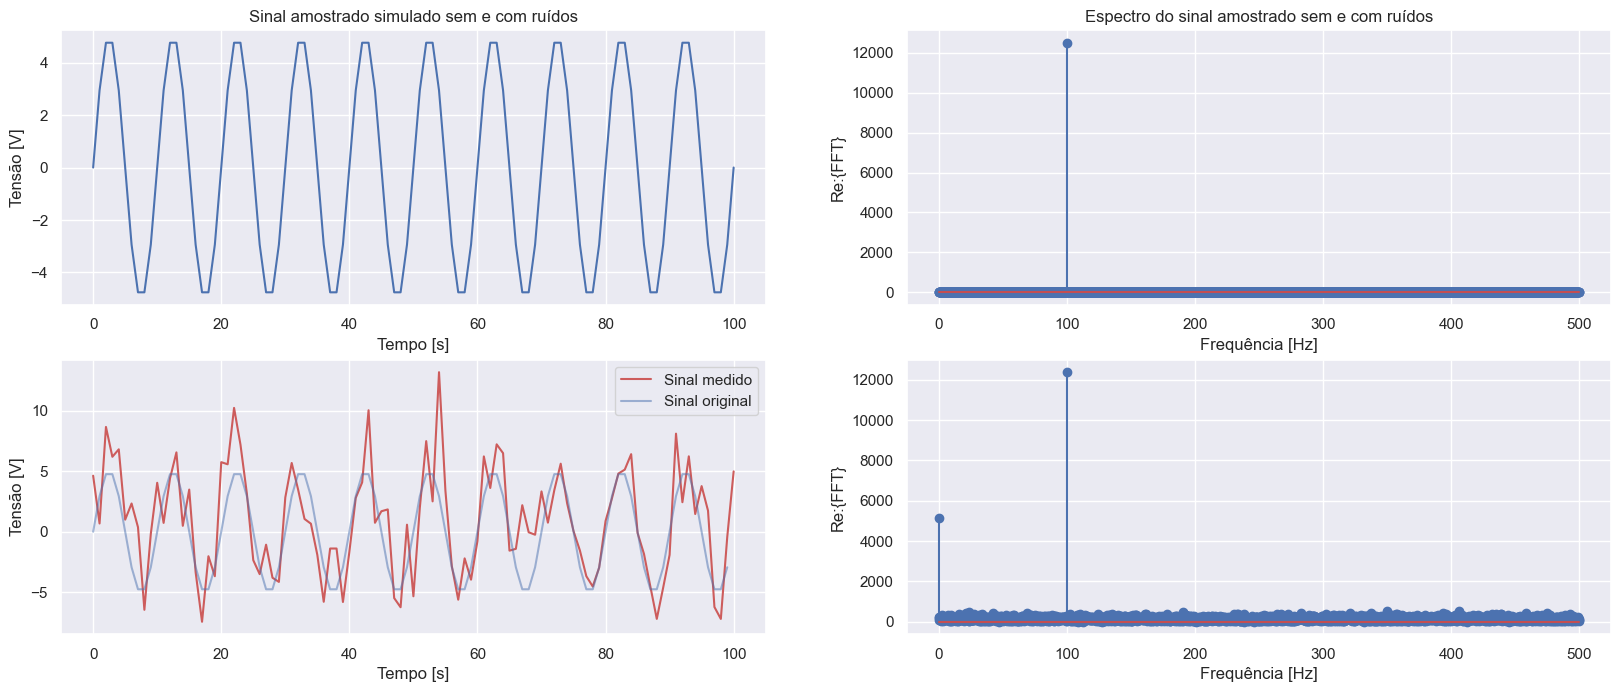

In [182]:
# Mostrando primeiros 20 segundos:

# Senoide 
plt.subplot(221);
sns.lineplot(y = sinal[0:round(20*N/(fs))+1], x = t[0:round(20*N/(fs))+1]);
# (2 ciclos = 20 seg => 10 seg / ciclo => fl = 1/10 = 0.1 Hz, frequencia normalizada f/fs, correta!)
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');
plt.title('Sinal amostrado simulado sem e com ruídos');

# FFT sinal
plt.subplot(222);
S = np.abs(fft(sinal))
F = fftfreq(len(S), d=1/fs)
plt.stem(F[0:round(len(F)/2)],S[0:round(len(S)/2)])
# plt.stem(F[0:300],S[0:300])
plt.ylabel('Re:{FFT}');
plt.xlabel('Frequência [Hz]');
plt.title('Espectro do sinal amostrado sem e com ruídos');

# Senoide + ruido
plt.subplot(223);
# Gerando ruído gaussiano de média zero, desvio padrão 1 e amplitude 5 (SNR = 10/2.5 = 4)
ruido = 2.5*rd.randn(N,) + 1
ruidoso = sinal + ruido
sns.lineplot(y = ruidoso[0:round(20*N/(fs))+1], x = t[0:round(20*N/(fs))+1], color = 'indianred');
sns.lineplot(y = sinal[0:round(20*N/(fs))], x = t[0:round(20*N/(fs))], alpha=0.5);
plt.legend(['Sinal medido', 'Sinal original']);
plt.ylabel('Tensão [V]');
plt.xlabel('Tempo [s]');


# FFT sinal ruidoso
plt.subplot(224);
R = np.abs(fft(ruidoso))
Fr = fftfreq(len(S), d=1/fs)
plt.stem(Fr[0:round(len(Fr)/2)],R[0:round(len(R)/2)]);
# plt.stem(F[0:300],S[0:300])
plt.ylabel('Re:{FFT}');
plt.xlabel('Frequência [Hz]');


def niasFFT(sinal, fs):
    S = fft(sinal)
    SINALf = np.abs(S)
    SINALa = np.angle(S)
    FREQs = fftfreq(len(sinal), d=1/fs)
    return [FREQs,SINALf, SINALa]

# Bin com pico de frequência: 
bin = np.where(S == max(S))
print('Bin',bin[0][0])
print('Frequência:',F[bin[0][0]], '=',f0,'(f0 do sinal original)')
print('Logo, para selecionar o valor da fft na f0, por exemplo:')
print('S[np.where(F==f0)[0][0]] =>',S[np.where(F==f0)[0][0]], '=', 'S[bin] = S[500] = ', S[500])
# Selecionar amostras de zero até TEMPO_DESEJADO (sem segundos) para plotar tempo contínuo referente:
# [0: round(TEMPO_DESEJADO*N/(fs))+1 ]

# 2 - Definições

## 2.1 - SFT: Spectral F-Test

### 2.1.1 - Definição e Funções

<img src = "sft.png"/>

In [5]:
def vc_SFT(L, alpha = 0.05, VERBOSE = 0):
    # valor crítico teórico, dado tomando inversa da distribuição acumulada F
    # (Fisher-Snedecor)
    # com significancia 1-alpha (95% se não for alterada)
    vc = FDIST.ppf(1-alpha, 2,2*L) 
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico SFT: ',vc)

    return vc
        #fce999 TODO: perguntar por que 2 e 2*L!

def ord_SFT(sinal, L, BIN):
    # L: tamanho das laterais
    SINAL = fft(sinal)

    central = round(BIN) # certifica inteiro (não float)
    lateralMenor = round(central-L/2)
    lateralMaior = round(central+L/2)+1       

    DEN =np.abs(SINAL[central])**2
    SINAL_lateral = np.array(list(SINAL[lateralMenor:central])+list(SINAL[central+1:lateralMaior])) 
    NUM = (1/L)*np.sum(np.abs(SINAL_lateral)**2)
    SFT = DEN/NUM
    
    return [SINAL,SFT]

## 2.2 - CSM: Component Synchrony Measure 

### 2.2.1 - Definição e Funções: 

<img src = "csm.png"/>

In [6]:
def vc_CSM(M, alpha = 0.05, VERBOSE=0):
    vc = chi2.ppf(1-alpha,2)/(2*M)
    
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico CSM: ',vc)

    return vc


def ord_CSM(sinal, tamanhoJanela, M):
    if len(sinal)-tamanhoJanela*M>=0:
        
        sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))


        FFT_SINAL = fft(sinal)

        CSM = (np.sum(np.cos(np.angle(FFT_SINAL)),axis=1)/M)**2 + (np.sum(np.sin(np.angle(FFT_SINAL)),axis=1)/M)**2

        return [FFT_SINAL,CSM]
    else:
        print('Erro no número de janelas', round(tamanhoJanela),'(ou amostras, M =', M,'\b) escolhido.')
        print('Tamanho do Sinal menos M*tamanhoJanela:', len(sinal)-M*tamanhoJanela)
        print('(Retorna 0)')
        return 0 

## 2.3 - MSC: Magnitude-Squared Coherence

### 2.3.1 - Definição e Funções

<img src = "msc.png"/>

In [7]:
def vc_MSC(M, alpha = 0.05, VERBOSE = 0):
    vc = 1-alpha**(1/(M-1))
    if VERBOSE==1:
        print('Significância desejada: ',alpha*100,'\b%')
    if VERBOSE==2:
        print('Significância desejada: ',alpha*100,'\b%')
        print('Valor crítico MSC: ',vc)
    return vc # valor crítico

def ord_MSC(sinal, tamanhoJanela, M):
    sinal = np.reshape(sinal[0:tamanhoJanela*M], (tamanhoJanela,M))

    SINAL = fft(sinal)
    
    MSC = (np.abs(np.sum(SINAL,axis=1))**2) / (M*np.sum(np.abs(SINAL)**2,axis=1))

    return [SINAL,MSC]

## 2.4 - Controle de significância (MSC)

### 2.4.1 - Definindo:

In [8]:
# Usando sequencial generalizado, queremos FP= 5% no teste GERAL! Qual deve ser FPi (cada iteração)?

def corrige_alfaMSC(
    tj = 100, # cada janela um segundo 
    Mmin = 10,
    Mstep = 10,
    Mmax = 60,
    BIN = 7,
    alphaD = 5/100,  #fff significancia a atingir
    alphaInicial = -1,
    tx_apr = 0.02,    # taxa de aprendizado
    nSim = 1e3, 
    itMAX = 300,
    VERBOSE = 1):

    print('\nCalculando alpha corrigido para alphaD =', alphaD)

    N = round(Mmax*tj)  # tamanho máximo do sinal
    nSim = round(nSim)  # numero de simulações
    if alphaInicial<0: alphas = [alphaD/(Mmax/Mstep)] # primeiro "chute" = alpha Desejado
    else: alphas = [alphaInicial]
    alphaR = 1   # significancia REAL
    it = 1  # iteração atual

    while alphaR > alphaD and it <= itMAX:
        if it>1:
            # Se J = mse = e^2 (univariado), então:
            grad = 2*alphaR - alphaD
            alphas.append(alphas[-1] -tx_apr*(grad))

        descricao = 'Iteração #'+str(it); it+=1; nd = 0; 
        
        if VERBOSE>=2:
            for _ in tqdm(range(1,nSim+1), leave=(VERBOSE>1), desc=descricao):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        if VERBOSE==1:
            for _ in tqdm(range(1,nSim+1), leave=False):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        else:
            for _ in range(1,nSim+1):
                x = rd.randn(N) # gera o "sinal" completo
                for M in range(Mmin, Mmax+Mstep,Mstep):
                    vc = vc_MSC(M,alpha=alphas[-1])            
                    [_, ORD]= ord_MSC(sinal=x, tamanhoJanela=tj, M=M)
                    if ORD[BIN]>vc: nd+=1

        alphaR = nd/(nSim*(Mmax/Mstep))


        if VERBOSE==3:
            print('Significancia atingida:',round(alphaR*100,ndigits=3),'\b%')
            print('Alpha corrigido:', round(alphas[-1],ndigits=3))

    if VERBOSE==1:
        print('Significancia atingida:',round(alphaR*100,ndigits=3),'\b%')
        print('Alpha corrigido:', round(alphas[-1],ndigits=4))
    
    if it>=itMAX: 
        print('Iteração máxima (',itMAX,') atingida!')
        print('Significancia alcançada:',round(alphaR*100,ndigits=3),'\b%')
        print('Retornando último valor de alpha corrigido: ', round(alphas[-1],ndigits=4))
    
    return alphas[-1]

# Exemplo:
print(corrige_alfaMSC(alphaD=0.04,VERBOSE=3))


Calculando alpha corrigido para alphaD = 0.04


Iteração #1: 100%|██████████| 1000/1000 [00:01<00:00, 706.86it/s]


Significancia atingida: 5.45%
Alpha corrigido: 0.007


Iteração #2: 100%|██████████| 1000/1000 [00:01<00:00, 995.02it/s]


Significancia atingida: 4.6%
Alpha corrigido: 0.005


Iteração #3: 100%|██████████| 1000/1000 [00:00<00:00, 1005.02it/s]


Significancia atingida: 4.25%
Alpha corrigido: 0.004


Iteração #4: 100%|██████████| 1000/1000 [00:00<00:00, 1162.82it/s]


Significancia atingida: 3.533%
Alpha corrigido: 0.003
0.0033466666666666666


# 3 - Validando meus resultados: 

## 3.1 - Validação teste da média:

In [9]:
# MC

## 3.2 - Validação SFT:

### 3.2.1 - Validação do valor crítico:

In [10]:
# MC:
nSim = round(500) # numero de simulações
N = 500  # "duração" do sinal
bin = 50 # um bin qualquer
Ls = np.arange(0,30,1)   # tamanho qualquer 
x = np.zeros((N,))
vcp = np.zeros((nSim,len(Ls)))
vct = np.zeros((nSim,len(Ls)))
oo = np.zeros((nSim,))

for ll in tqdm(range(0,len(Ls)), desc='Simulando'):
    for ii in range(0,nSim):
        x = rd.randn(N,)
        [X,ORD] = ord_SFT(sinal=x, L=Ls[ll], BIN= bin)
        oo[ii] = ORD
        vct[ii][ll] = vc_SFT(Ls[ll])
    
    vcp[ll] = vc_pratico(oo) # alpha definido a 5%

print('Pronto')

Simulando:   0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-5-f4504bd5937d>:26: RuntimeWarning: divide by zero encountered in long_scalars
  NUM = (1/L)*np.sum(np.abs(SINAL_lateral)**2)
<ipython-input-5-f4504bd5937d>:26: RuntimeWarning: invalid value encountered in double_scalars
  NUM = (1/L)*np.sum(np.abs(SINAL_lateral)**2)
<ipython-input-5-f4504bd5937d>:27: RuntimeWarning: divide by zero encountered in double_scalars
  SFT = DEN/NUM
Simulando: 100%|██████████| 30/30 [00:02<00:00, 10.20it/s]

Pronto


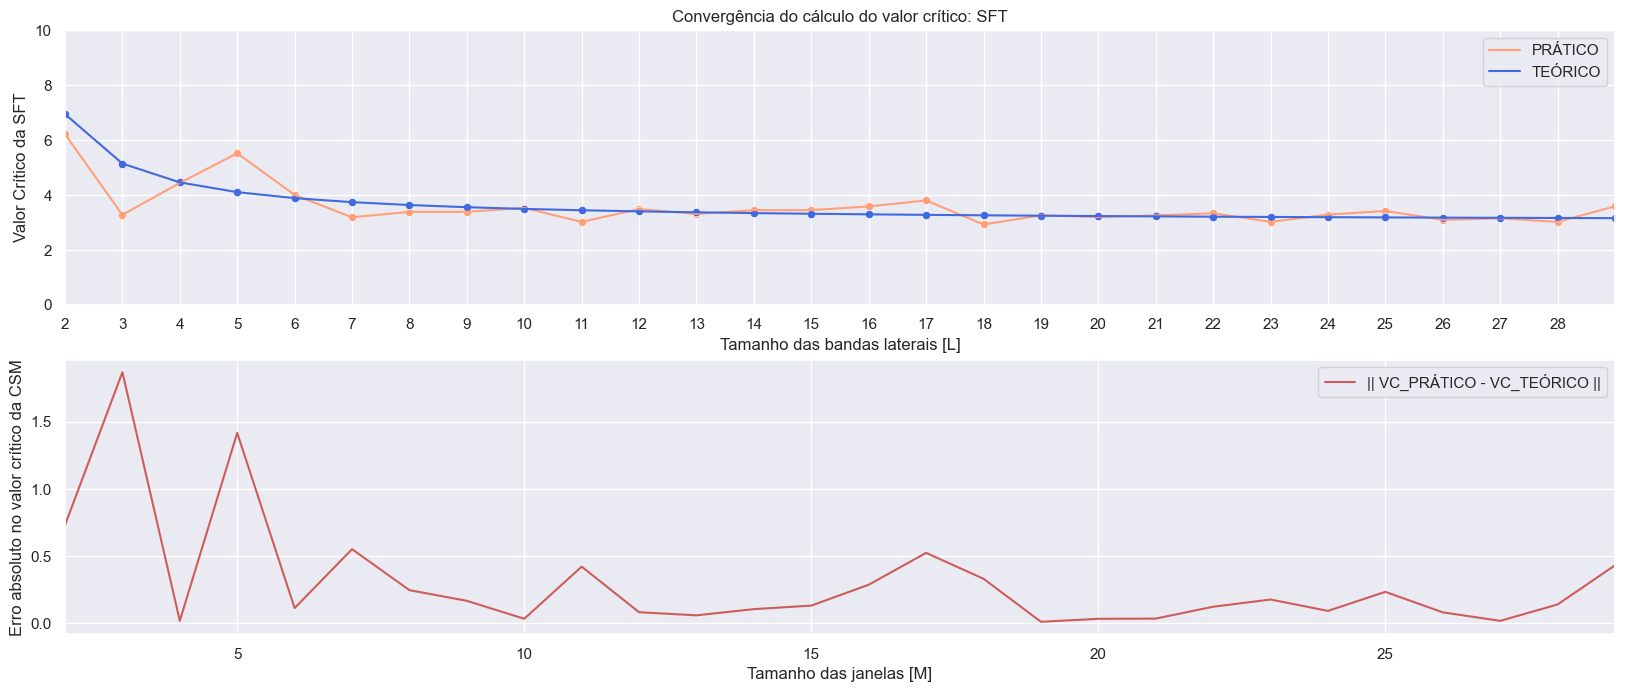

In [11]:
plt.subplot(211)
p = sns.lineplot(data = np.mean(vcp,axis=1), color = 'lightsalmon') 
p = sns.lineplot(data = np.mean(vct,axis=0), color = 'royalblue') 

plt.xticks(np.arange(0,max(Ls),1));
plt.xlim([2, max(Ls)]);
plt.ylim([0,10]);
plt.title('Convergência do cálculo do valor crítico: SFT');
plt.ylabel('Valor Crítico da SFT');
plt.xlabel('Tamanho das bandas laterais [L]');

sns.scatterplot(data = np.mean(vcp,axis=1), color = 'lightsalmon'); 
sns.scatterplot(data = np.mean(vct,axis=0), color = 'royalblue'); 
plt.legend(['PRÁTICO','TEÓRICO']);

plt.subplot(212)
p2 = sns.lineplot(x = Ls,y= abs(np.mean(vcp,axis=1)[0:len(np.mean(vct,axis=0))]-np.mean(vct,axis=0)), color = 'indianred') 
plt.ylabel('Erro absoluto no valor crítico da CSM');
plt.legend(['|| VC_PRÁTICO - VC_TEÓRICO ||']);
plt.xlabel('Tamanho das janelas [M]');
plt.xlim([2, Ls[-1]]);

### 3.2.2 - Validação SFT: Single-shot MC

In [225]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)
N = int(1e4) # num. de pontos na senóide

# Calcula senóide base e frequência para encontrar bins:
f0 = 120
fs = 1000
L = 20
amp = 1
x = senoide(amplitude=amp, N=N, f0 = f0, fs=fs)
[F, _, _] = niasFFT(sinal = x, fs=fs)
bin_f0 = np.where(F==f0)[0][0]

amplitudeRuido = 20 # SNR = 20*ln(1/20) = -200
alpha = 0.04
limiar = vc_SFT(L=L, alpha=alpha)
nd = 0
hist = np.zeros((nSim,))

for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    sinal = x + amplitudeRuido*rd.randn(N,)
    
    # Calcula SFT na f0:
    [_, ORD]= ord_SFT(sinal=sinal, L=L, BIN=bin_f0)

    # Detecção?
    if ORD > limiar: nd +=1

    hist[i] = ORD


print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')


Simulando: 100%|██████████| 10000/10000 [00:04<00:00, 2441.77it/s]

Probabilidade de detecção atingida: 85.56%
(PD esperada =  96.0%)


### 3.2.3 - Validação SFT: Curva PD(SNR)

In [ ]:
nSim = int(1e4) # num. de simulações (sen+ruido=>ord=>detecção?)
N = int(1e4) # num. de pontos na senóide

# Calcula senóide base e frequência para encontrar bins:
f0 = 120
fs = 1000
L = 20
amp = 1
x = senoide(amplitude=amp, N=N, f0 = f0, fs=fs)
[F, _, _] = niasFFT(sinal = x, fs=fs)
bin_f0 = np.where(F==f0)[0][0]

amplitudeRuido = 20 # SNR = 20*ln(1/20) = -200
alpha = 0.04
limiar = vc_SFT(L=L, alpha=alpha)
nd = 0
hist = np.zeros((nSim,))

for i in tqdm(range(0,nSim), desc = 'Simulando'):
    # Soma ruido aleatório novo à senóide inicial, em cada simulação:
    sinal = x + amplitudeRuido*rd.randn(N,)
    
    # Calcula SFT na f0:
    [_, ORD]= ord_SFT(sinal=sinal, L=L, BIN=bin_f0)

    # Detecção?
    if ORD > limiar: nd +=1

    hist[i] = ORD


print('Probabilidade de detecção atingida:', (nd/nSim)*100,'\b%')
print('(PD esperada = ',100*(1-alpha),'\b%)')


## 3.3 Validação CSM:

### 3.3.1 - Validação do valor crítico:

In [12]:
# MC:
nSim = round(500) # numero de simulações
tj = 100
Mmin = 10
Mmax = 400
Mstep = 10
bin = 50 # um bin qualquer
Ms = np.arange(Mmin,Mmax+Mstep,Mstep)   # tamanho qualquer 
print(len(Ms))
x = np.zeros((N,))
vcp = np.zeros((nSim,len(Ms)))
vct = np.zeros((nSim,len(Ms)))
oo = np.zeros((nSim,tj))

for mm in tqdm(range(0,len(Ms)), desc='Simulando'):
    for ii in range(0,nSim):
        N = Ms[mm]*tj  # "duração" do sinal
        x = rd.randn(N,)
        [X,ORD] = ord_CSM(sinal=x, tamanhoJanela=tj, M=Ms[mm])
        oo[ii,:] = ORD
        vct[ii][mm] = vc_CSM(Ms[mm])
    
    vcp[mm] = vc_pratico(oo) # alpha definido a 5%

print('Pronto')

40


Simulando: 100%|██████████| 40/40 [01:00<00:00,  1.51s/it]

Pronto


(10.0, 400.0)

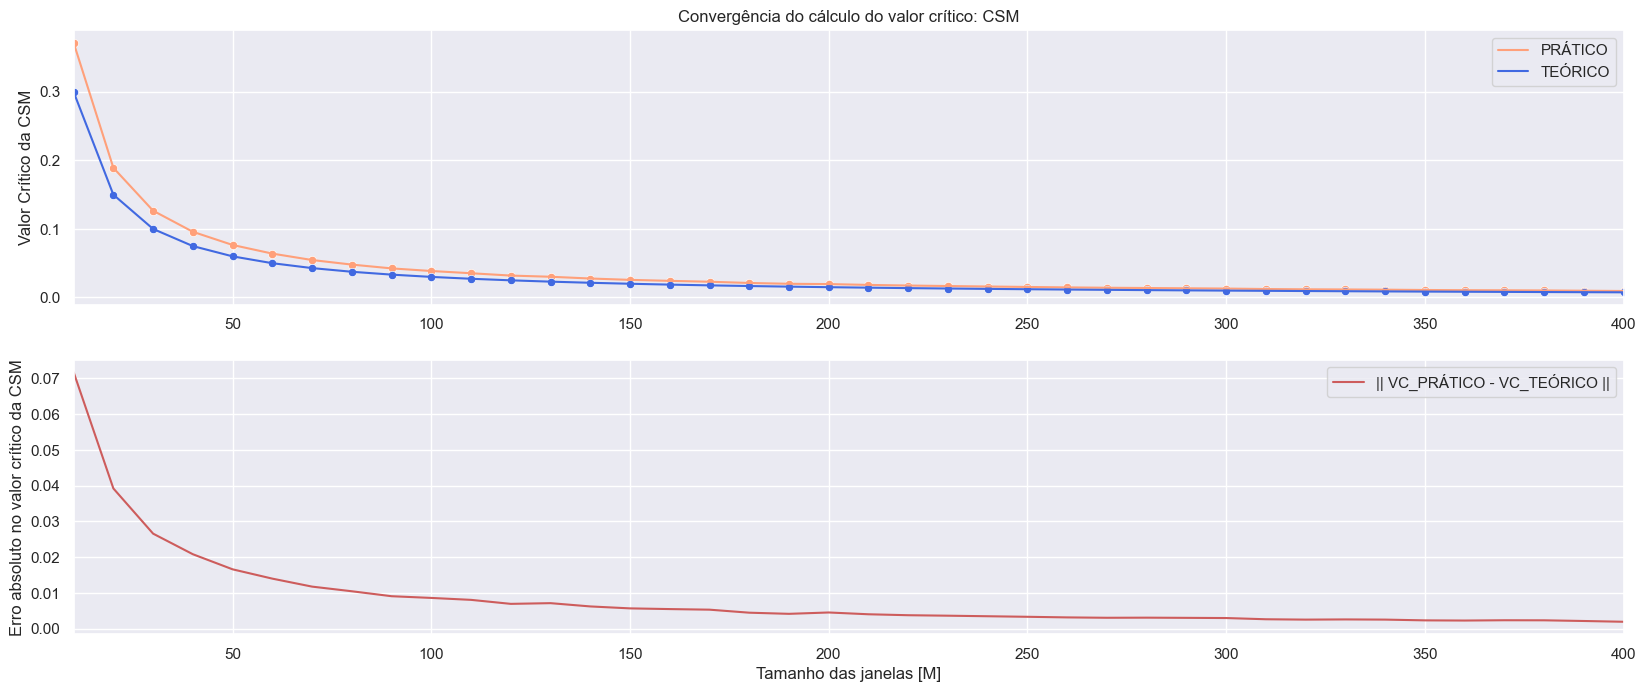

In [13]:
plt.subplot(211)
p = sns.lineplot(x = Ms,y= np.mean(vcp,axis=1)[0:40], color = 'lightsalmon') 
p = sns.lineplot(x = Ms,y = np.mean(vct,axis=0), color = 'royalblue') 

plt.title('Convergência do cálculo do valor crítico: CSM');
plt.ylabel('Valor Crítico da CSM');


sns.scatterplot(x = Ms,y= np.mean(vcp,axis=1)[0:40], color = 'lightsalmon'); 
sns.scatterplot(x = Ms,y = np.mean(vct,axis=0), color = 'royalblue'); 
plt.legend(['PRÁTICO','TEÓRICO']);
plt.xlim([10, 400]);

plt.subplot(212)
p2 = sns.lineplot(x = Ms,y= abs(np.mean(vcp,axis=1)[0:40]-np.mean(vct,axis=0)), color = 'indianred') 
plt.ylabel('Erro absoluto no valor crítico da CSM');
plt.legend(['|| VC_PRÁTICO - VC_TEÓRICO ||']);
plt.xlabel('Tamanho das janelas [M]');
plt.xlim([10, 400]);


### 3.3.2 - Validação MC CMS:

## 3.4 Validação MSC:

### 3.4.1 - Validação do valor crítico:

In [14]:
# MC:
nSim = round(500) # numero de simulações
tj = 100
Mmin = 10
Mmax = 400
Mstep = 10
bin = 50 # um bin qualquer
Ms = np.arange(Mmin,Mmax+Mstep,Mstep)   # tamanho qualquer 
x = np.zeros((N,))
vcp = np.zeros((nSim,len(Ms)))
vct = np.zeros((nSim,len(Ms)))
oo = np.zeros((nSim,tj))

for mm in tqdm(range(0,len(Ms)), desc='Simulando'):
    for ii in range(0,nSim):
        N = Ms[mm]*tj  # "duração" do sinal
        x = rd.randn(N,)
        [X,ORD] = ord_MSC(sinal=x, tamanhoJanela=tj, M=Ms[mm])
        oo[ii,:] = ORD
        vct[ii][mm] = vc_MSC(Ms[mm])
    
    vcp[mm] = vc_pratico(oo) # alpha definido a 5%

print('Pronto')

Simulando: 100%|██████████| 40/40 [00:19<00:00,  2.10it/s]

Pronto


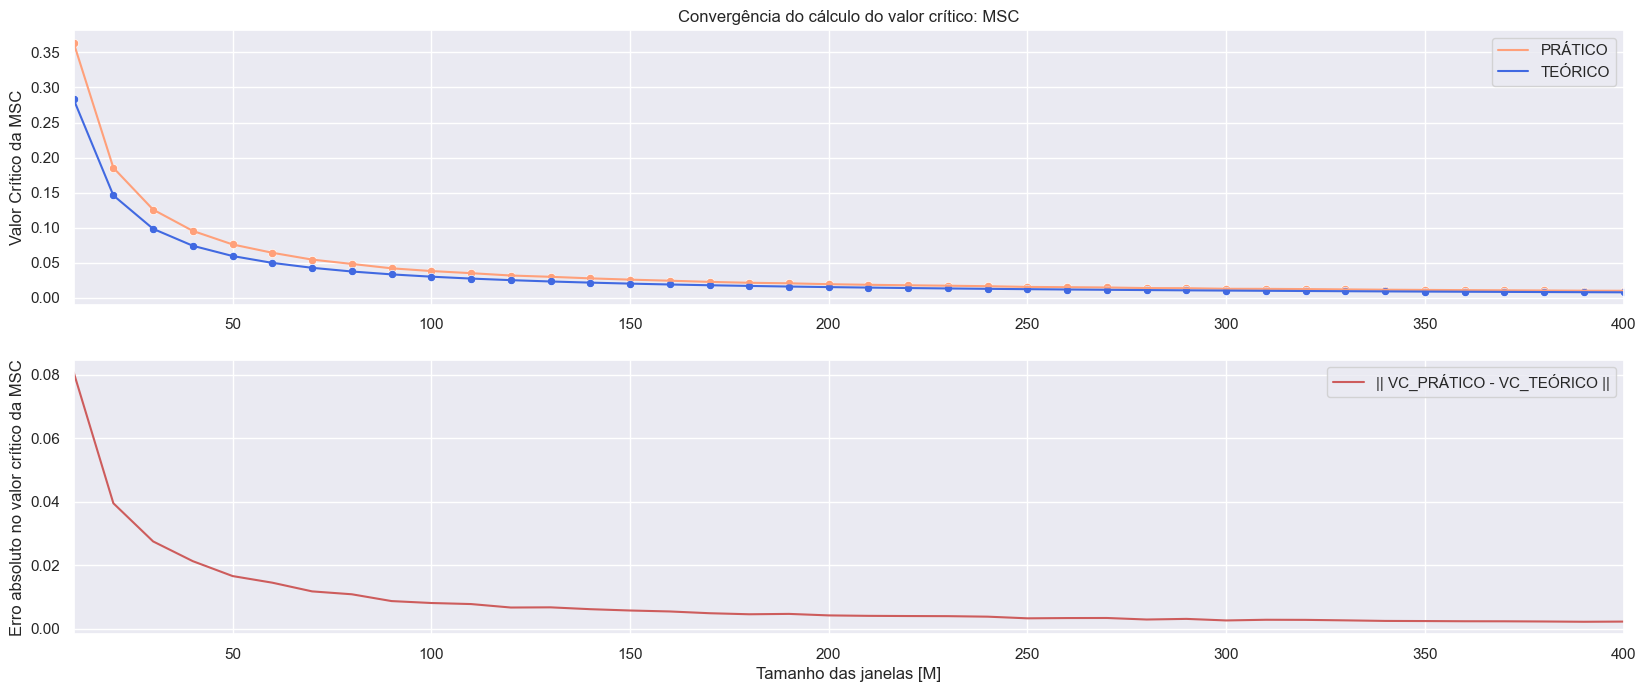

In [15]:
plt.subplot(211)
p = sns.lineplot(x = Ms,y= np.mean(vcp,axis=1)[0:40], color = 'lightsalmon') 
p = sns.lineplot(x = Ms,y = np.mean(vct,axis=0), color = 'royalblue') 

plt.title('Convergência do cálculo do valor crítico: MSC');
plt.ylabel('Valor Crítico da MSC');


sns.scatterplot(x = Ms,y= np.mean(vcp,axis=1)[0:40], color = 'lightsalmon'); 
sns.scatterplot(x = Ms,y = np.mean(vct,axis=0), color = 'royalblue'); 
plt.legend(['PRÁTICO','TEÓRICO']);
plt.xlim([10, 400]);

plt.subplot(212)
p2 = sns.lineplot(x = Ms,y= abs(np.mean(vcp,axis=1)[0:40]-np.mean(vct,axis=0)), color = 'indianred') 
plt.ylabel('Erro absoluto no valor crítico da MSC');
plt.legend(['|| VC_PRÁTICO - VC_TEÓRICO ||']);
plt.xlabel('Tamanho das janelas [M]');
plt.xlim([10, 400]);

### 3.3.2 - Validação MC MSC: